# Analyze 42-qubit problem with 3 objective functions

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from qamoo.utils.data_structures import ProblemGraphBuilder
from qamoo.utils.utils import evaluate_sample_objectives

import pygmo as pg

In [2]:
problem_folder = './../data/problems/42q/problem_set_42q_0s_3o_0/'

In [3]:
figures_folder = './../figures/'

In [4]:
# get objective graphs
num_objectives = 3
objective_graphs = [
        ProblemGraphBuilder.deserialize(
            problem_folder + f'problem_graph_{idx}.json')
        for idx in range(num_objectives)
    ]

# load reference point
reference_point = np.array(json.load(open(problem_folder + 'lower_bounds.json')))

## DCM Results

In [5]:
scaling = 1000

In [6]:
# read samples
with open(problem_folder + f'results/dcm/dcm_3o_{scaling}.sol', 'r') as f:
    s = f.read()
 
lines = s.split('\n')
solutions_x = ''
for line in lines:
    if line[:8] == 'Solution':
        solutions_x += line
solutions_x = solutions_x.split('Solution for NDP ')[1:]
solutions_x = [s.split(':')[1].replace(' =', '=')[1:-1] for s in solutions_x]
dcm_samples = []
for s in solutions_x:
    vvals = s.split(' ')
    x = []
    ids = []
    for v in vvals:
        v_ = v.split('=')
        v_name = v_[0].split('[')[0]
        v_val = int(np.round(float(v_[1])))
        if v_name[0] == 'n':
            ids += [int(v_name[2:])]
            x += [v_val]
    x = np.array(x)
    idx = np.argsort(ids)
    x = x[idx]
    dcm_samples += [x]
dcm_samples = np.array(dcm_samples)

In [7]:
# evaluate number of non-dominated points for HW
fvals = evaluate_sample_objectives(dcm_samples, objective_graphs)
print('#fvals  =', len(fvals))

#fvals  = 2063


In [8]:
# read samples
with open(problem_folder + f'results/dcm/dcm_3o_{scaling}.sol', 'r') as f:
    s = f.read()
# NDP 2058: 185 -3202 -20664 Time: 27.7169
lines = s.split('\n')
times = np.zeros(len(fvals))
for line in lines:
    if line[:4] == 'NDP ':
        s = line[4:].split(':')
        times[int(s[0])-1] = float(s[-1])

idx = np.argsort(times)
times = times[idx]
fvals = fvals[idx]

In [9]:
# ----------------------------------
# uncomment to run - requires pygmo
# ----------------------------------

# dcm_progress = {}
# num_steps = 100
# steps = np.array(np.round(np.linspace(0, len(times)-1, num_steps)), dtype=int)
# t = 0
# for i in tqdm(steps):
#     t = times[i]
#     f_hv = pg.hypervolume(-np.array(fvals)[:(i+1)])
#     hv = f_hv.compute(-reference_point)
#     dcm_progress[str(t)] = hv

# with open(problem_folder + f'results/dcm/dcm_3o_{scaling}_progress.json', 'w') as f:
#     json.dump(dcm_progress, f)

In [10]:
with open(problem_folder + f'results/dcm/dcm_3o_{scaling}_progress.json', 'r') as f:
    dcm_progress = json.load(f)

In [11]:
x_dcm = np.array([float(x_) for x_ in dcm_progress.keys()])
y_dcm = np.array(list(dcm_progress.values()))

## DPA Results

In [12]:
scaling = 1000

In [13]:
# read variables names
variable_names = []
variable_indices = []
variable_positions = []
cnt = 0
with open(problem_folder + 'results/dpa/dpa_variables.txt', 'r') as f:
    s = f.read()
    lines = s.split('\n')
    for l in lines:    
        if l[0] == 'n':
            variable_names += [l]
            variable_indices += [int(l[2:])]
            variable_positions += [cnt]
        cnt += 1
idx = np.argsort(variable_indices)
pos = np.array(variable_positions)[idx]

In [14]:
# read samples
with open(problem_folder + f'results/dpa/3o_{scaling}/dpa_3o_{scaling}_x.sol', 'r') as f:
    s = f.read()
 
lines = s.split('\n')
solutions_x = ''
for line in lines:
    solutions_x += line
solutions_x = [s.replace('[', '').replace(']', '') for s in solutions_x.split('][')]
print(len(solutions_x))
dpa_samples = []
for x in solutions_x:
    x = [int(np.round(float(x_))) for x_ in x.split(',')]
    dpa_samples += [np.array(x)[pos]]
dpa_samples = np.array(dpa_samples)

2063


In [15]:
# evaluate number of non-dominated points for HW
fvals = evaluate_sample_objectives(dpa_samples, objective_graphs)
print('#fvals  =', len(fvals))

#fvals  = 2063


In [16]:
# read samples
with open(problem_folder + f'results/dpa/3o_{scaling}/dpa_3o_{scaling}_progress.sol', 'r') as f:
    s = f.read()
    
times = [float(i) for i in s.split('\n')[:-1]]
t_start = -1
ts = []
num = []
for t in times:
    if t == t_start:
        num[-1] += 1
    else:
        t_start = t
        ts += [t]
        num += [1]

In [17]:
# ----------------------------------
# uncomment to run - requires pygmo
# ----------------------------------

# dpa_progress = {}
# num_steps = 100
# steps = np.array(np.round(np.linspace(0, len(times)-1, num_steps)), dtype=int)
# for i in tqdm(steps):
#     num_points = sum(num[:(i+1)])
#     f_hv = pg.hypervolume(-np.array(fvals)[:num_points])
#     hv = f_hv.compute(-reference_point)
#     dpa_progress[str(times[i])] = hv

# with open(problem_folder + f'results/dpa/dpa_3o_{scaling}_progress.json', 'w') as f:
#     json.dump(dpa_progress, f)

In [18]:
with open(problem_folder + f'results/dpa/dpa_3o_{scaling}_progress.json', 'r') as f:
    dpa_progress = json.load(f)

In [19]:
x_dpa = np.array([float(x_) for x_ in dpa_progress.keys()])
y_dpa = np.array(list(dpa_progress.values()))

## $\epsilon$-Constraint Method

In [20]:
num_eps_samples = 459629
num_c_samples = 1  # per eps sample
run_id = 0

In [21]:
with open(problem_folder + f'results/random_eps_constraint_{num_eps_samples}_samples_{num_c_samples}_shots_{run_id}/progress.json', 'r') as f:
    eps_progress = json.load(f)

In [22]:
x_eps = np.array([float(x_) for x_ in eps_progress.keys()])
y_eps = np.array(list(eps_progress.values()))

## MPS / HW Rresults

In [23]:
try:
    with open(problem_folder + 'time_records.json') as f:
        time_records = json.load(f)
    avg_times = {}
    for k in time_records:
        avg_times[k] = np.mean(time_records[k]['times'])
    print(avg_times)
except:
    print('no time records found!')

{'GWO': np.float64(0.6340864133834839), 'R_EPS': np.float64(0.021756649017333984), 'WS': np.float64(0.003933672904968262), 'B_R': np.float64(0.015240433216094971)}


In [24]:
t_shot = 0.0001             # time per shot / sample
t_eps = avg_times['R_EPS']  # time per MIP / sample

In [25]:
import os
from pathlib import Path

progress = {}
folder = Path(problem_folder + 'results/')
for f in os.scandir(folder):
    if f.is_dir():
        alg_name = f.path.split('/')[-1]
        try:
            progress[alg_name] = json.load(open(f.path + '/progress.json'))
        except:
            pass            

In [26]:
alg_names = sorted(list(progress.keys()))
values = []
for alg_name in alg_names:
    values += [max(progress[alg_name].values())]

In [27]:
idx = np.argsort(values)[::-1]

In [28]:
mps_path = lambda chi, p, i: f'{problem_folder}results/qaoa_aer_simulator_matrix_product_state_v2_p_{p}_5000_samples_5000_shots_{chi}_{i}/'
hw_path = lambda p, i: f'{problem_folder}results/qaoa_ibm_fez_v2_p_{p}_5000_samples_5000_shots_f{i}/'

In [29]:
mps_results = {}  # chi / p / id
for chi in [1, 5, 10, 20, 30, 50]:
    mps_results[chi] = {}
    for p in range(1, 7):
        mps_results[chi][p] = []
        for i in range(5):
            try:
                with open(mps_path(chi, p, i) + 'progress.json') as f:
                    progress = json.load(f)

                x = sorted([int(t) for t in progress.keys()])
                mps_results[chi][p] += [[progress[str(x_)] for x_ in x]]
            except:
                # pass
                print(f'no results for ({chi}, {p}, {i})')
        mps_results[chi][p] = np.array(mps_results[chi][p])

In [30]:
hw_results = {}  # p / id
for p in [3, 4, 5, 6]:
    hw_results[p] = []
    for i in range(5):
        try:
            with open(hw_path(p, i) + 'progress.json') as f:
                progress = json.load(f)

            x = sorted([int(t) for t in progress.keys()])
            hw_results[p] += [[progress[str(x_)] for x_ in x]]
        except:
            # pass
            print(f'no results for ({p}, {i})')
    hw_results[p] = np.array(hw_results[p])

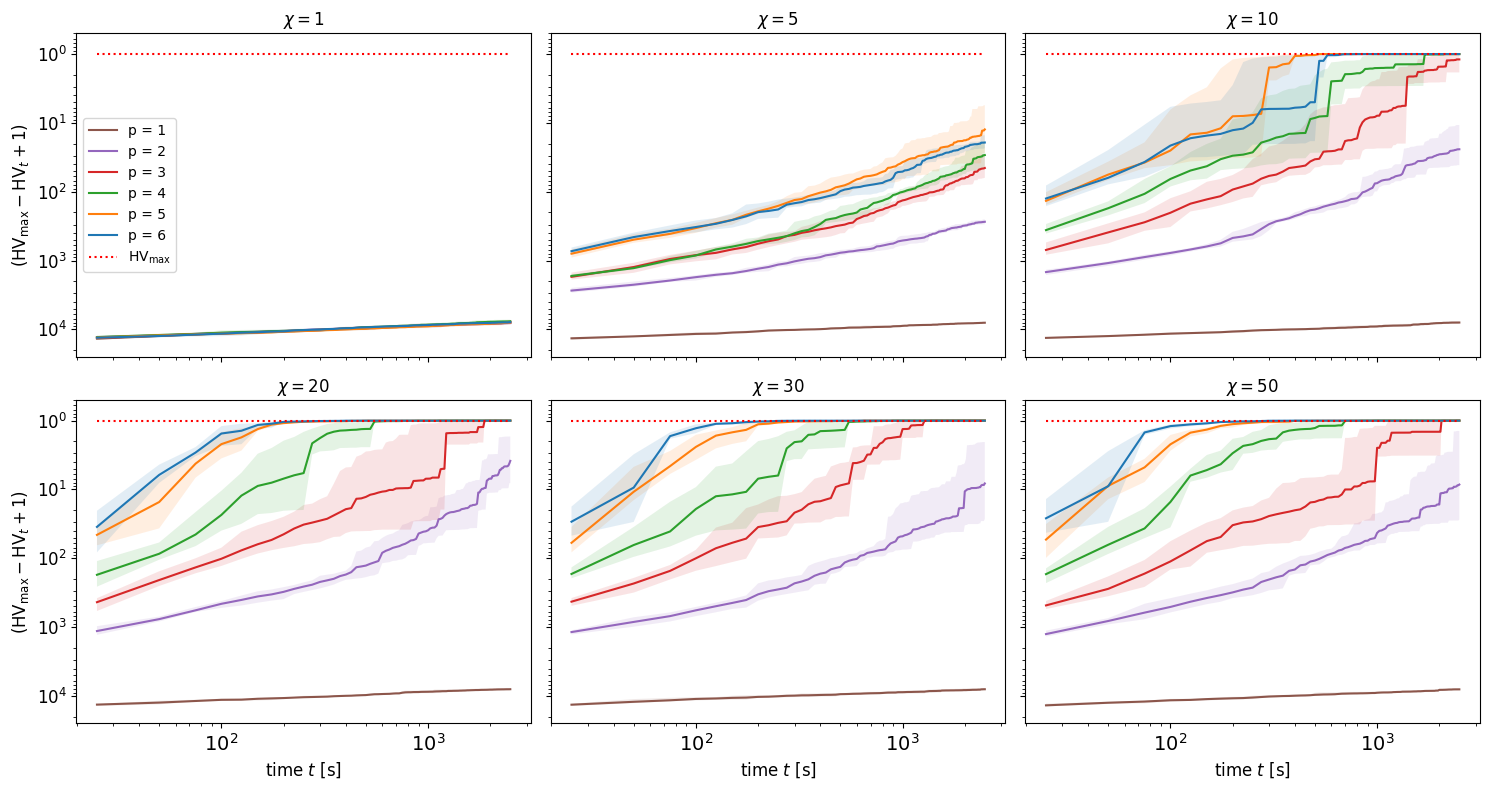

In [31]:
x = np.array(x) * t_shot

hv_max = 43471.70365440166
g = lambda y: hv_max + 1 - y

plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
plt.subplot(2, 3, 1)
plt.ylabel(r'$(\text{HV}_{\text{max}} - \text{HV}_t + 1)$', fontsize=12)

colors = plt.cm.tab10(range(6))[::-1]
p_max = 6
for i, chi in enumerate([1, 5, 10, 20, 30, 50]):

    plt.subplot(2, 3, i+1)
    plt.title(fr'$\chi = {chi}$')
    for p in range(1, p_max+1):
    
        ys = mps_results[chi][p]
        if len(ys) > 0:
            y_mu = np.mean(ys, axis=0)
            y_sigma = np.std(ys, axis=0)
    
            if i == 0:
                plt.loglog(x, g(y_mu), '-', label=rf'p = {p}', color=colors[p-1])
            else:
                plt.loglog(x, g(y_mu), '-', color=colors[p-1])
            plt.fill_between(x, g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)
        else:
            print('skip', chi, p)
        
    if i == 0:
        plt.loglog(x, np.ones(len(x)), 'r:', label=r'$\text{HV}_{\text{max}}$')
    else:
        plt.loglog(x, np.ones(len(x)), 'r:')


    if i == 0 or i == 3:
        plt.ylabel(r'$(\text{HV}_{\text{max}} - \text{HV}_t + 1)$', fontsize=12)
    
    plt.ylim(0.5, 25_000)
    if i > 2:
        plt.xlabel(r'time $t$ [s]', fontsize=12)
    plt.yticks([1, 10, 100, 1000, 10000], fontsize=12)
    plt.xticks(fontsize=14)
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend(loc='center left', fontsize=10)

plt.tight_layout()
plt.savefig(f'{figures_folder}42q_3o_mps_sim_results.pdf')
plt.show()

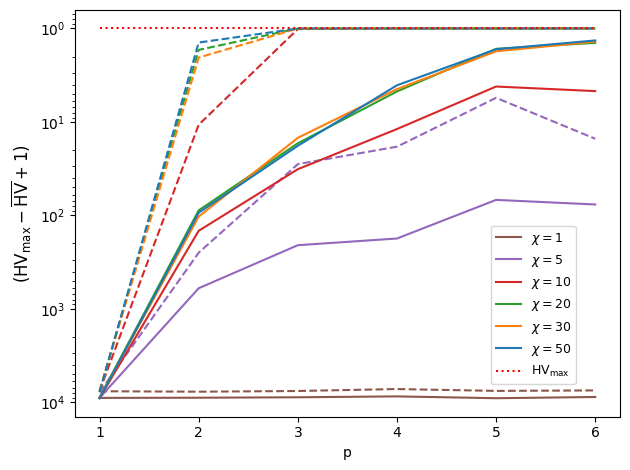

In [32]:
markers = ['']*6
max_hv = {}
avg_hv = {}
for i, chi in enumerate([1,5,10,20,30,50]):
    avg_hv[chi] = []
    max_hv[chi] = []
    for p in range(1, p_max+1):
        try:
            avg_hv[chi] += [(1 + hv_max - np.mean(mps_results[chi][p]))]
            max_hv[chi] += [(1 + hv_max - np.max(mps_results[chi][p]))]
        except:
            pass
        
    plt.semilogy(range(1, len(avg_hv[chi])+1), avg_hv[chi], f'{markers[i]}-', label=f'$\chi = {chi}$', color=colors[i])
    plt.semilogy(range(1, len(max_hv[chi])+1), max_hv[chi], f'--', color=colors[i])
plt.semilogy([1, 6], [1, 1], 'r:', label=r'$\text{HV}_{\text{max}}$')
plt.gca().invert_yaxis()
plt.legend(loc=(0.7625, 0.08), fontsize=9)
plt.ylabel(r'$(\text{HV}_{\text{max}} - \overline{\text{HV}} + 1)$', fontsize=12)
plt.xlabel('p')
plt.tight_layout()
plt.savefig(f'{figures_folder}42q_3o_mps_sim_results_avg.pdf')
plt.show()

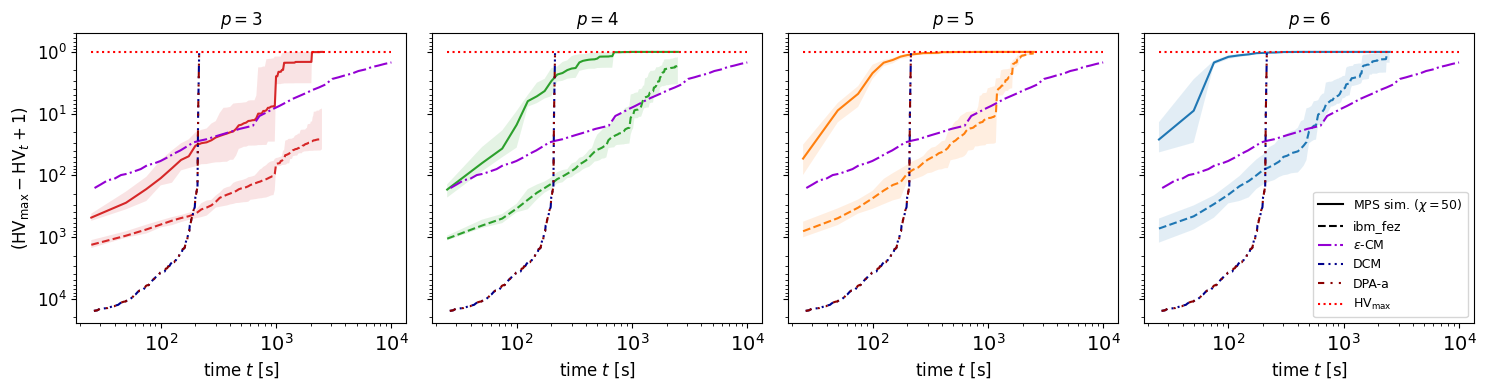

In [33]:
hv_max = 43471.70365440166
g = lambda y: hv_max + 1 - y

eps_max = max(y_eps)

chi = 50
p_min = 3
p_max = 6
plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)
for p in range(p_min, p_max+1):
    
    plt.subplot(1, 4, p - p_min + 1)
    plt.title(rf'$p = {p}$')

    ys = mps_results[chi][p]
    y_mu = np.mean(ys, axis=0)
    y_sigma = np.std(ys, axis=0)
    factor = 1
    
    plt.loglog(factor*x, g(y_mu), '-', color=colors[p-1])
    plt.loglog(25, 1, '-', color='black', label=r'MPS sim. ($\chi = 50$)')
    plt.loglog(25, 1, '--', color='black', label='ibm_fez')
    plt.fill_between(factor*x, g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)

p_min = 3
p_max = 6
for p in range(p_min, p_max+1):

    plt.subplot(1, 4, p - p_min + 1)

    ys = hw_results[p]
    y_mu = np.mean(ys, axis=0)
    y_sigma = np.std(ys, axis=0)
    
    plt.loglog(factor*x, g(y_mu), '--', color=colors[p-1])
    plt.fill_between(factor*x, g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)
    
    plt.xlabel(r'time $t$ [s]', fontsize=12)
    plt.xticks(fontsize=14)
    
    plt.ylim(0.5, 25_000)
    plt.yticks([1, 10, 100, 1000, 10000], fontsize=12)
    
    plt.gca().invert_yaxis()

    x_, y_ = t_eps * x_eps, y_eps
        
    idx = sum(x_ < 25)
    end = sum(x_ <= 10000)
    x_ = x_[idx:end]
    y_ = np.array(y_)[idx:end]
    eps_max_T = g(y_[-1])
    plt.loglog(x_, g(np.array(y_)), '-.', color='darkviolet', label=rf'$\epsilon$-CM')

    idx_dcm = sum(x_dcm < 25)
    dashdotdotted = (0, (3, 2, 1, 2, 1, 2))
    plt.loglog(x_dcm[idx_dcm:], g(y_dcm[idx_dcm:]), linestyle=dashdotdotted, color='darkblue', label=rf'DCM')

    idx_dpa = sum(x_dpa < 25)
    dashdotdotted = (0, (3, 3, 1, 3, 1, 3))
    plt.loglog(x_dpa[idx_dpa:], g(y_dpa[idx_dpa:]), linestyle=dashdotdotted, color='darkred', label=rf'DPA-a')
    
    plt.loglog([25, 10000], [1, 1], 'r:', label=r'$\text{HV}_{\text{max}}$')

plt.subplot(1, 4, 4)
plt.legend(loc='lower right', fontsize=9)

plt.subplot(1, 4, 1)
plt.ylabel(r'$(\text{HV}_{\text{max}} - \text{HV}_t + 1)$', fontsize=12)
plt.tight_layout()

plt.savefig(f'{figures_folder}42q_3o_hw_results.pdf')
plt.show()

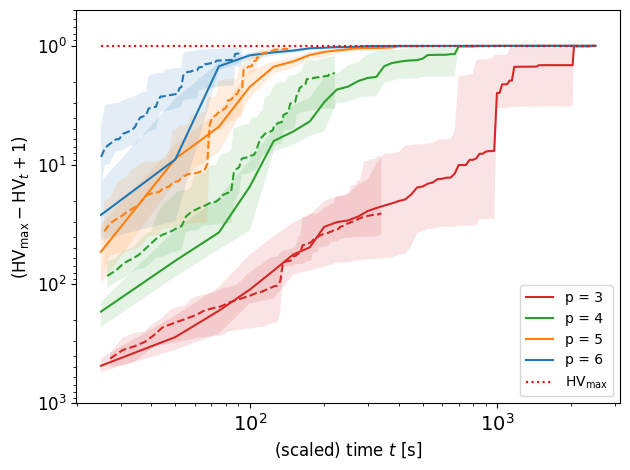

In [34]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


hv_max = 43471.70365440166
g = lambda y: hv_max + 1 - y

chi = 50
p_min = 3
p_max = 6
for p in range(p_min, p_max+1):
    ys = mps_results[chi][p]
    y_mu = np.mean(ys, axis=0)
    y_sigma = np.std(ys, axis=0)
    
    plt.loglog(x, g(y_mu), '-', label=rf'p = {p}', color=colors[p-1])
    plt.fill_between(x, g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)


p_min = 3
p_max = 6
fidelities = [0.1363, 0.0884, 0.0573, 0.0371]
for p in range(p_min, p_max+1):

    ys = hw_results[p]
    y_mu = np.mean(ys, axis=0)
    y_sigma = np.std(ys, axis=0)

    x_ = fidelities[p-3] * np.array(x)

    i = sum(x_ < 25)
   
    plt.loglog(x_[i:], g(y_mu)[i:], '--', color=colors[p-1])    
    plt.fill_between(x_[i:], g(np.min(ys, axis=0))[i:], g(np.max(ys, axis=0))[i:], edgecolor='none', facecolor=colors[p-1], alpha=0.125)


plt.loglog([25, 2500], [1, 1], 'r:', label=r'$\text{HV}_{\text{max}}$')
    
#plt.xlim(1, 2525)
plt.ylim(0.5, 1_000)
plt.xlabel(r'(scaled) time $t$ [s]', fontsize=12)
plt.yticks([1, 10, 100, 1000], fontsize=12)
plt.xticks(fontsize=14)
plt.gca().invert_yaxis()

plt.ylabel(r'$(\text{HV}_{\text{max}} - \text{HV}_t + 1)$', fontsize=12)
plt.tight_layout()
plt.legend(loc='lower right')
plt.savefig(f'{figures_folder}42q_3o_hw_results_scaled.pdf')
plt.show()